<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/denoiser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
!pip install pandas_ta

In [115]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [48]:
df = pd.read_csv('/content/drive/MyDrive/eurusd_hour.csv')
close = df['AC']
open = df['AO']
high = df['AH']
low = df['AL']
change = df['ACh']
print(df)

             Date   Time       BO       BH       BL       BC      BCh  \
0      2005-05-02  00:00  1.28520  1.28520  1.28400  1.28440 -0.00080   
1      2005-05-02  01:00  1.28440  1.28480  1.28390  1.28420 -0.00020   
2      2005-05-02  02:00  1.28430  1.28540  1.28410  1.28510  0.00080   
3      2005-05-02  03:00  1.28510  1.28590  1.28500  1.28510  0.00000   
4      2005-05-02  04:00  1.28520  1.28590  1.28490  1.28550  0.00030   
...           ...    ...      ...      ...      ...      ...      ...   
93079  2020-04-29  18:00  1.08620  1.08851  1.08611  1.08713  0.00093   
93080  2020-04-29  19:00  1.08711  1.08823  1.08659  1.08748  0.00037   
93081  2020-04-29  20:00  1.08747  1.08788  1.08691  1.08708 -0.00039   
93082  2020-04-29  21:00  1.08708  1.08740  1.08699  1.08714  0.00006   
93083  2020-04-29  22:00  1.08728  1.08760  1.08727  1.08743  0.00015   

            AO       AH       AL       AC      ACh  
0      1.28540  1.28540  1.28420  1.28460 -0.00080  
1      1.28460  1

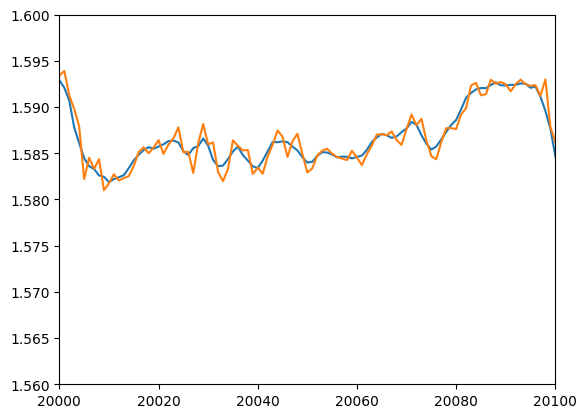

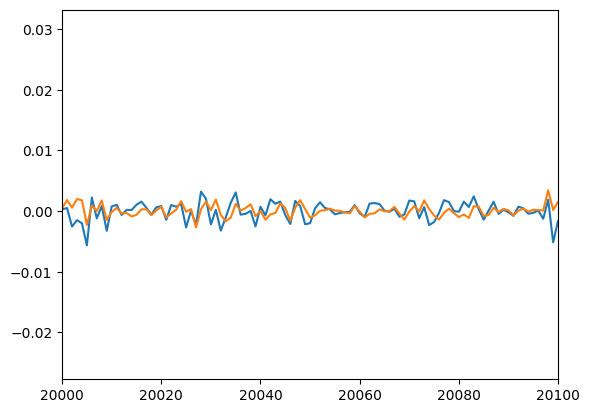

In [63]:
SMA = ta.sma(close,4,offset=-2)
NOISE = close-SMA
plt.xlim(20000,20100)
plt.ylim(1.56,1.6)
plt.plot(SMA)
plt.plot(close)
plt.show()
plt.xlim(20000,20100)
plt.plot(change)
plt.plot(NOISE)
plt.show()

In [137]:
# Define the window length and stride
window_length = 10
stride = 1

changed = pd.Series(change,name='change')
NOISED = pd.Series(NOISE,name='noise')
combined_series = pd.concat([changed, NOISED], axis=1)
combined_series = combined_series.dropna(axis=0)
print(combined_series)
noise = combined_series.pop('noise')
changed = combined_series.pop('change')

# Create the sliding window view for time_series_1
changed = sliding_window_view(changed, window_length)[::stride]
NOISED = np.roll(noise, -window_length+1)
NOISED = NOISED[:changed.shape[0]]

changed = changed/np.std(changed)
NOISED = NOISED/np.std(NOISED)



        change     noise
1     -0.00020 -0.000500
2      0.00080  0.000125
3      0.00000 -0.000175
4      0.00030  0.000050
5      0.00000 -0.000150
...        ...       ...
93077 -0.00049 -0.001162
93078  0.00179  0.000037
93079  0.00066 -0.000130
93080  0.00035 -0.000050
93081  0.00050  0.000345

[93081 rows x 2 columns]


[0.2911 -0.8086 -0.0647 ... 0.4270 0.2264 0.3235]
[0.7172 -0.4955 0.2947 ... -0.1356 -0.0522 0.3599]


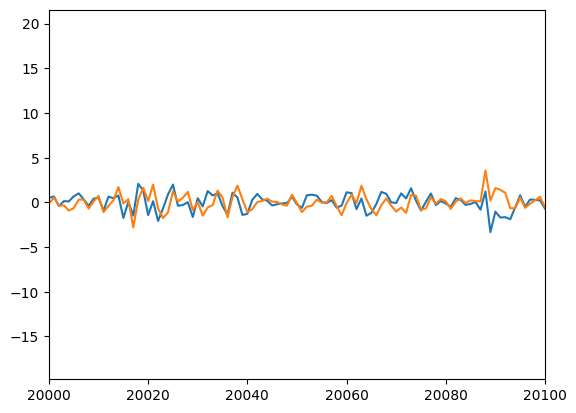

In [138]:

print(changed[:, -1])
print(NOISED)


plt.xlim(20000,20100)
plt.plot(changed[:, -1])
plt.plot(NOISED)


In [139]:
def activity_regularizer(multiplier, decay=0.99):
    # Initialize moving averages for mean and variance
    mean_avg = tf.Variable(0.0, trainable=False, name='mean_avg')
    variance_avg = tf.Variable(1.0, trainable=False, name='variance_avg')

    def regularizer(y_pred):
        # Calculate the current mean and variance
        current_mean = tf.reduce_mean(y_pred)
        current_variance = tf.math.reduce_variance(y_pred)

        # Update moving averages
        update_mean = tf.compat.v1.assign(mean_avg, decay * mean_avg + (1 - decay) * current_mean)
        update_variance = tf.compat.v1.assign(variance_avg, decay * variance_avg + (1 - decay) * current_variance)

        with tf.control_dependencies([update_mean, update_variance]):
            # Use the moving averages for regularization
            mean = mean_avg
            variance = variance_avg

        return multiplier * (tf.square(mean - 0) + tf.square(variance - 1))

    return regularizer

In [145]:
reg = activity_regularizer(.01)

# Create a sequential model
model = Sequential()

# Add layers to the model
model.add(Dense(64, activation='relu',activity_regularizer=reg))
model.add(Dense(64, activation='relu',activity_regularizer=reg))
model.add(Dense(64, activation='relu',activity_regularizer=reg))
model.add(Dense(1, activation=None))

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [146]:
X_train=changed
y_train=NOISED

model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
2909/2909 [==============================] - 6s 2ms/step - loss: 0.8506 - mae: 0.5891
Epoch 2/10
2909/2909 [==============================] - 6s 2ms/step - loss: 0.8401 - mae: 0.5836
Epoch 3/10
2909/2909 [==============================] - 5s 2ms/step - loss: 0.8367 - mae: 0.5828
Epoch 4/10
2909/2909 [==============================] - 5s 2ms/step - loss: 0.8358 - mae: 0.5829
Epoch 5/10
2909/2909 [==============================] - 6s 2ms/step - loss: 0.8336 - mae: 0.5819
Epoch 6/10
2909/2909 [==============================] - 5s 2ms/step - loss: 0.8330 - mae: 0.5814
Epoch 7/10
2909/2909 [==============================] - 5s 2ms/step - loss: 0.8315 - mae: 0.5811
Epoch 8/10
2909/2909 [==============================] - 5s 2ms/step - loss: 0.8292 - mae: 0.5811
Epoch 9/10
2909/2909 [==============================] - 7s 2ms/step - loss: 0.8270 - mae: 0.5808
Epoch 10/10
2909/2909 [==============================] - 5s 2ms/step - loss: 0.8243 - mae: 0.5803


In [147]:
prediction = model.predict(X_train)

2909/2909 [==============================] - 4s 1ms/step


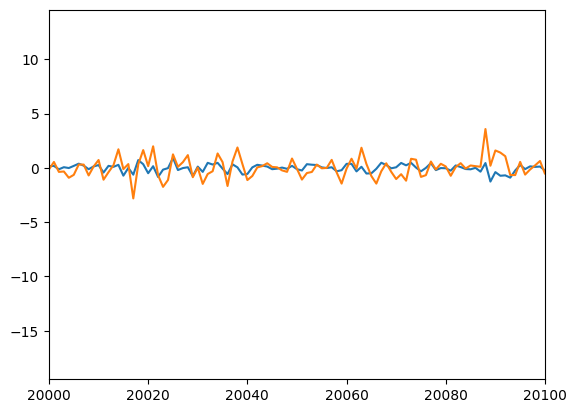

In [148]:
plt.xlim(20000,20100)
plt.plot(prediction)
plt.plot(y_train)